# PhD course CIBUSmod lab
This notebook runs CIBUSmod for a scenario co-designed by participants at the PhD course *Monitoring of Food System Sustainability*, given at SLU Uppsala in November 2024. It relies on the main [CIBUSmod](https://github.com/SLU-foodsystems/CIBUSmod) code being placed in the parent directory of the directory containing this notebook and scenario Excel woorkbooks.

Here is a [link](https://github.com/SLU-foodsystems/CIBUSmod/tree/93150797d4e87a72b6e6e6f0cc0f630fbe058eb9) to the exact version of CIBUSmod used.

### Imports
Add directory with the CIBUSmod modules to path to be able to import

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(),'../CIBUSmod'))

Import CIBUSmod and packages for handling data and plotting

In [2]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Set up scenarios

Instantiate a `Session` object and define scenarios

In [3]:
# Create session
session = cm.Session(
    name = 'phd_lab',
    data_path = '../CIBUSmod/data',
    data_path_scenarios='',
    data_path_output=''
)

In [4]:
years = list(range(2020,2050+1,10))

session.add_scenario(
    name = 'Baseline',
    scenario_workbooks = ['baseline'],
    years = years
)

session.add_scenario(
    name = 'PhD scn',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = years
)

# Here a number of scenarios are defined that step by step
# include additional paramters of the 'PhD scn' scenario
# to be able to asses the impacts of different assumptions
session.add_scenario(
    name = '+demand',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions']
)

session.add_scenario(
    name = '+crops',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction']
)

session.add_scenario(
    name = '+cattle',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd']
)

session.add_scenario(
    name = '+pigs',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
              'PigHerd']
)

session.add_scenario(
    name = '+poultry',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
              'PigHerd', 'BroilerHerd', 'LayerHerd']
)

session.add_scenario(
    name = '+waste',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
              'PigHerd', 'BroilerHerd', 'LayerHerd', 'WasteAndCircularity']
)

A scenario with the name 'Baseline' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name 'PhD scn' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+demand' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+crops' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+cattle' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+pigs' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+poultry' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+waste' already exists use .update_scenario() or .remove_scenario() instead.


### Run calculations

In [5]:
# Import
from concurrent.futures import ProcessPoolExecutor, as_completed
from multi_proc import do_run

# Create list of scenarios/years to run
# runs = [(s,y) for s, y in session.iterate('all')]
# runs = [(s,y) for s, y in session.iterate(['PhD scn'])]
runs = [(s,y) for s, y in session.iterate(['PhD scn','+demand', '+crops', '+cattle', '+pigs', '+poultry', '+waste'])]
runs

[('PhD scn', '2020'),
 ('PhD scn', '2030'),
 ('PhD scn', '2040'),
 ('PhD scn', '2050'),
 ('+demand', '2050'),
 ('+crops', '2050'),
 ('+cattle', '2050'),
 ('+pigs', '2050'),
 ('+poultry', '2050'),
 ('+waste', '2050')]

In [6]:
%%time
# Do the multi-processing
with ProcessPoolExecutor(max_workers=8) as executor:
    
    futures = {executor.submit(do_run, session, scn_year) : scn_year for scn_year in runs}

    for future in as_completed(futures):
    
        scn, year = futures[future]
           
        try:
            t = future.result()
        except Exception as ee:
            print(f'(!!!) {scn}, {year} failed with the exception: {ee}')
        else:
            m = int(t/60)
            s = int(round(t - m*60))
            print(f'{scn}, {year} finished successfully in {m}min {s}s')
                    

+crops, 2050 finished successfully in 3min 43s
+cattle, 2050 finished successfully in 3min 57s
PhD scn, 2040 finished successfully in 4min 33s
PhD scn, 2050 finished successfully in 4min 49s
+pigs, 2050 finished successfully in 5min 3s
PhD scn, 2030 finished successfully in 5min 9s
PhD scn, 2020 finished successfully in 5min 9s
+demand, 2050 finished successfully in 5min 18s
+poultry, 2050 finished successfully in 2min 32s
+waste, 2050 finished successfully in 2min 32s
CPU times: total: 15.6 ms
Wall time: 6min 35s


## Plot output
Here are some example output plots.

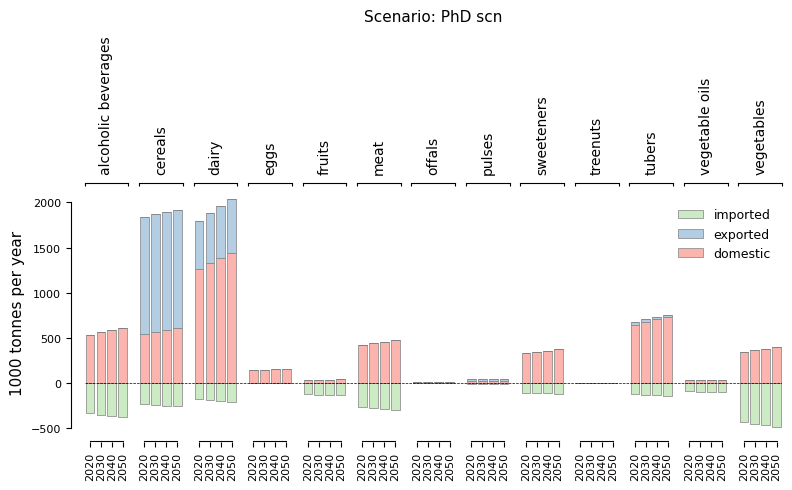

In [7]:
style = {
    'cmap' : 'Pastel1',
    'edgecolor' : 'grey',
    'bar_width' : 0.8,
    'group_spacing' : 1,
    'grouplabels_fontsize' : 10,
    'ticklabels_fontsize' : 8,
    'totmarker' : 'none',
    'ylabel' : '1000 tonnes per year'
}

plot_data = (
    session.get_attr(
        module='D',
        attr='food_demand_to_processing',
        groupby=['origin','food_group']
    ).add(
        session.get_attr(
            module='D',
            attr='export_demand',
            groupby=['origin','food_group']
        ).rename(columns={'domestic':'exported'}),
        fill_value = 0
    )
    .stack()
    .fillna(0)
)/1000000
plot_data.loc[:,'imported'] = -plot_data.loc[:,'imported']

fig, ax = plt.subplots(figsize=(9,3))
cm.plot.bar(plot_data.loc['PhD scn'], group_levels='food_group', grouplabels_vertical=True, grouptitle='Scenario: PhD scn', ax=ax, **style)
plt.show()

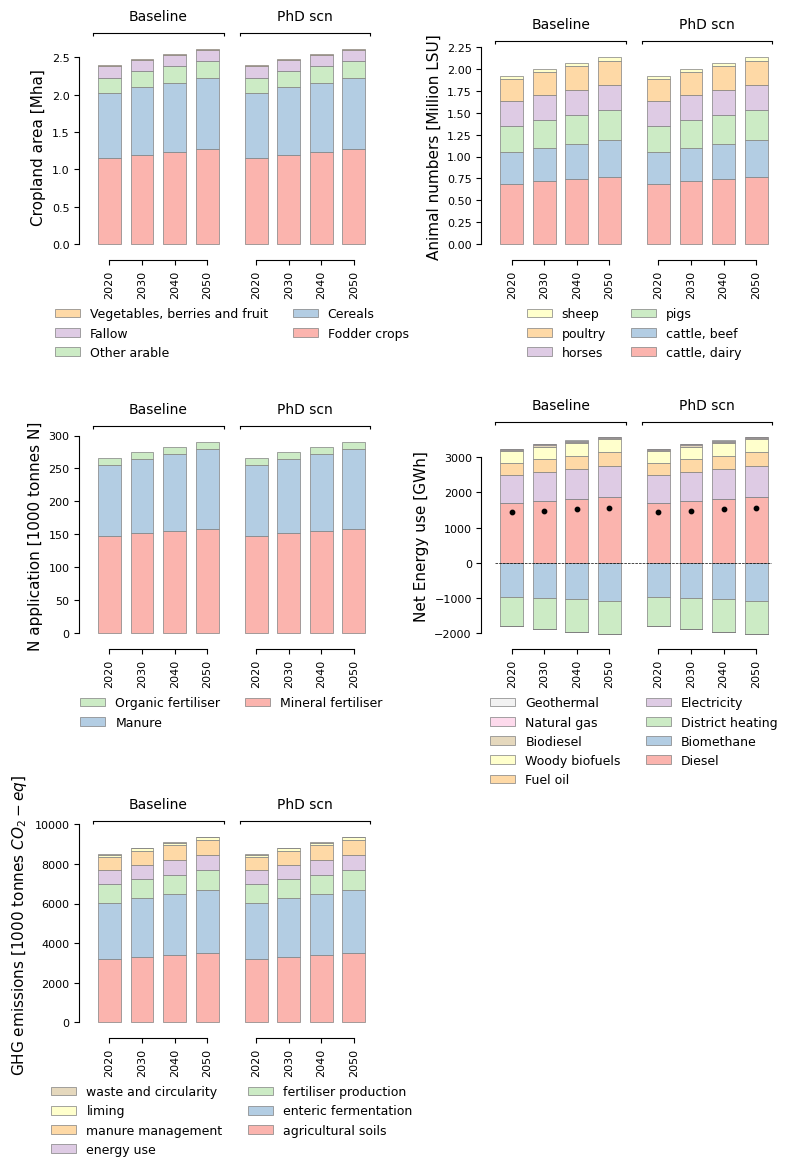

In [18]:
style = {
    'stacked' : True,
    'cmap' : 'Pastel1',
    'edgecolor' : 'grey',
    'ticklabels_fontsize' : 8,
    'bar_width' : 0.7
}

def _LSU(x):
    '''Gives livestock units (LSU) per head based on a tuple of (species, breed, animal)
    according to https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Livestock_unit_(LSU)'''
    sp,br,an = x
    if sp == 'cattle':
        if an == 'cows':
            if br == 'dairy':
                return 1
            else:
                return 0.8
        elif an == 'calves':
            return 0.4
        elif an == 'breeding bulls':
            return 1
        else:
            return 0.8
    elif sp == 'sheep':
        return 0.1
    elif sp == 'pigs':
        if an == 'piglets':
            return 0.027
        elif an == 'sows':
            return 0.5
        else:
            return 0.3
    elif sp == 'horses':
        return 0.8
    elif sp == 'poultry':
        if an == 'broilers':
            return 0.007
        else:
            return 0.014
    else:
        return np.nan

fig, axs = plt.subplots(3,2, figsize=(8,12))

# Cropland --->
ax = axs[0,0]
plot_data = session.get_attr('C','area',{'crop':'crop_group2'}, scn=['Baseline', 'PhD scn'])/1000000
plot.bar(
    plot_data.drop(['Semi-natural grasslands','Greenhouse crops'], axis=1),
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='Cropland area [Mha]'
)

# Animals --->
ax = axs[0,1]
plot_data = session.get_attr('a','heads',['species','breed','animal'], scn=['Baseline', 'PhD scn'])
# Convert to LSU
plot_data = plot_data.mul([_LSU(x) for x in plot_data.columns], axis=1)
# Keep dairy/beef separate
idx = plot_data.columns.to_frame(index=False)
idx['species'] = idx['species'].where(idx['species'] != 'cattle',idx['species']+', '+idx['breed'])
plot_data.columns = pd.MultiIndex.from_frame(idx)
plot_data = plot_data.T.groupby('species').sum().T/1_000_000
plot.bar(
    plot_data,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='Animal numbers [Million LSU]'
)

# N application --->
ax = axs[1,0]
plot.bar(
    pd.concat([
        session.get_attr('C','fertiliser.mineral_N',{'crop':'land_use'}, scn=['Baseline', 'PhD scn']).loc[:,'cropland'].rename('Mineral fertiliser'),
        session.get_attr('C','fertiliser.manure_N',{'crop':'land_use'}, scn=['Baseline', 'PhD scn']).loc[:,'cropland'].rename('Manure'),
        session.get_attr('C','fertiliser.organic_N',{'crop':'land_use'}, scn=['Baseline', 'PhD scn']).loc[:,'cropland'].rename('Organic fertiliser'),
    ], axis=1)/1_000_000,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='N application [1000 tonnes N]'
)

# Net Energy use --->
ax = axs[1,1]
plot_data = (
    pd.concat([
        session.get_attr('C','energy_use','energy_source', scn=['Baseline', 'PhD scn']),
        session.get_attr('A','energy_use','energy_source', scn=['Baseline', 'PhD scn']),
        session.get_attr('W','energy_use', 'energy_source', scn=['Baseline', 'PhD scn']),
        -session.get_attr('W','energy_prod','energy_prod', scn=['Baseline', 'PhD scn']).rename_axis(columns='energy_source')
    ], axis=1)
    .T.groupby('energy_source').sum().T
)/1_000_000
plot.bar(
    plot_data,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel='Net Energy use [GWh]'
)

# GHG emissions
ax = axs[2,0]
plot_data = (
    cm.get_GHG(session, scn=['Baseline', 'PhD scn'])
    .T.groupby('process').sum().T
)/1000000
plot.bar(
    plot_data,
    **style,
    ax=ax,
    sort_categories=True,
    group_levels='scn',
    ylabel=r'GHG emissions [1000 tonnes $CO_{2}-eq$]'
)

for ax in axs.flatten():
    if ax==axs.flatten()[-1]:
        ax.axis('off')
        continue
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.25), fontsize=9, frameon=False, reverse=True)

plt.tight_layout()
plt.show()

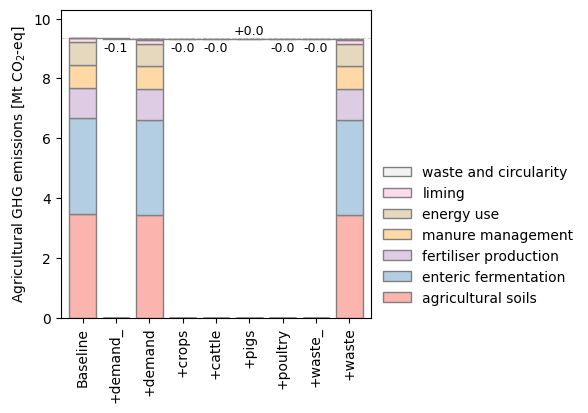

In [9]:
fig, ax = plt.subplots(figsize=(4,4))

plot_data1 = (
    cm.get_GHG(session, scn=['Baseline','+demand', '+crops', '+cattle', '+pigs', '+poultry', '+waste'], years='2050')
    .T.groupby('process').sum().T
    .droplevel('year')
)/1_000_000_000

# Sort
s = plot_data1.loc['Baseline'].sort_values(ascending=False).index

plot.waterfall(
    data=plot_data1.loc[:,s],
    ax=ax,
    breaks = ['+demand'],
    cmap='Pastel1',
    edgecolor='grey',
    width=0.8,
    label='absolute',
    label_size=9
)

ax.axhline(y=plot_data1.sum(axis=1).loc['Baseline'], xmin=0, xmax=1, zorder=0, linestyle='--', linewidth=0.8, color='lightgrey')

ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel('Agricultural GHG emissions [Mt CO$_2$-eq]')
ax.set_ylim(top=plot_data1.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False, reverse=True)

plt.show()